In [1]:
import torch
from transformers import CLIPModel

from abc import ABC, abstractmethod
from typing import Any, List
from transformers import AutoProcessor
from torchvision.transforms import (CenterCrop, Compose, InterpolationMode,
                                    Normalize, Resize)

from transformers import BertTokenizer

import torch
from torch import nn
import torch.nn.functional as F

import os
from urllib.parse import urlparse
from timm.models.hub import download_cached_file

import torch

class BaseRewardLoss(ABC):
    """
    Base class for reward functions implementing a differentiable reward function for optimization.
    """

    def __init__(self, name: str, weighting: float):
        self.name = name
        self.weighting = weighting

    @staticmethod
    def freeze_parameters(params: torch.nn.ParameterList):
        for param in params:
            param.requires_grad = False

    @abstractmethod
    def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        pass

    @abstractmethod
    def get_text_features(self, prompt: str) -> torch.Tensor:
        pass

    @abstractmethod
    def compute_loss(
        self, image_features: torch.Tensor, text_features: torch.Tensor
    ) -> torch.Tensor:
        pass

    def process_features(self, features: torch.Tensor) -> torch.Tensor:
        features_normed = features / features.norm(dim=-1, keepdim=True)
        return features_normed

    def __call__(self, image: torch.Tensor, prompt: str) -> torch.Tensor:
        image_features = self.get_image_features(image)
        text_features = self.get_text_features(prompt)

        image_features_normed = self.process_features(image_features)
        text_features_normed = self.process_features(text_features)

        loss = self.compute_loss(image_features_normed, text_features_normed)
        return loss

class CLIPLoss(BaseRewardLoss):
    """CLIP reward loss function for optimization."""

    def __init__(
        self,
        weigthing: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str,
        tokenizer,
        memsave: bool = False,
    ):
        self.tokenizer = tokenizer
        self.clip_model = CLIPModel.from_pretrained(
            "laion/CLIP-ViT-H-14-laion2B-s32B-b79K",
            cache_dir=cache_dir,
        )
        # freeze all models parameters
        if memsave:
            import memsave_torch.nn

            self.clip_model = memsave_torch.nn.convert_to_memory_saving(self.clip_model)

        self.clip_model = self.clip_model.to(device, dtype=dtype)
        self.clip_model.eval()
        self.freeze_parameters(self.clip_model.parameters())
        super().__init__("CLIP", weigthing)
        self.clip_model.gradient_checkpointing_enable()

    def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        clip_img_features = self.clip_model.get_image_features(image)
        return clip_img_features

    def get_text_features(self, prompt: str) -> torch.Tensor:
        prompt_token = self.tokenizer(
            prompt, return_tensors="pt", padding=True, max_length=77, truncation=True
        ).to("cuda")
        clip_text_features = self.clip_model.get_text_features(**prompt_token)
        return clip_text_features

    def compute_loss(
        self, image_features: torch.Tensor, text_features: torch.Tensor
    ) -> torch.Tensor:
        clip_loss = (
            100
            - (image_features @ text_features.T).mean()
            * self.clip_model.logit_scale.exp()
        )
        return clip_loss



/usr/local/lib/python3.10/dist-packages/timm/models/hub.py:4: FutureWarning: Importing from timm.models.hub is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !git clone https://github.com/salesforce/BLIP
    %cd BLIP
    !pip install transformers timm fairscale


Running in Colab.
fatal: destination path 'BLIP' already exists and is not an empty directory.
/content/BLIP


In [3]:
from models.blip import blip_feature_extractor
from models.blip_itm import blip_itm

# model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base.pth'
model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'
# model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large.pth'
class BLIPLoss(BaseRewardLoss):
    """BLIP reward loss function for optimization."""

    def __init__(
        self,
        weighting: float,
        dtype: torch.dtype,
        device: torch.device,
        cache_dir: str,
        memsave: bool = False,
    ):
        # Initialize BLIP model
        # self.blip_model = blip_feature_extractor(pretrained=model_url, vit='base')
        self.blip_model = blip_itm(pretrained=model_url,image_size = 224, vit='base')

        self.blip_model = self.blip_model.to(device, dtype=dtype)
        self.blip_model.eval()
        self.freeze_parameters(self.blip_model.parameters())
        super().__init__("BLIP", weighting)

    def get_image_features(self, image: torch.Tensor) -> torch.Tensor:
        """
        Extract image features using the BLIP visual encoder.
        """
        with torch.no_grad():
            image_features = self.blip_model(image, "", mode='image')[0,0]  # Use "image" mode
        return image_features

    def get_text_features(self, prompt: str) -> torch.Tensor:
        """
        Extract text features using the BLIP text encoder.
        """
        with torch.no_grad():
            text_features = self.blip_model(torch.tensor([]).to(device), prompt, mode='text')[0,0]  # Use "text" mode
        return text_features

    def compute_loss(
        self, image: torch.Tensor, text: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute the BLIP loss.
        """
        score = self.blip_model(image , text , 'itc')
        # out = self.blip_model(image , text , 'itm')
        # score = torch.nn.functional.softmax(out, dim=1)[:, 1]
        return - score


    # def compute_loss(
    #     self, image_features: torch.Tensor, text_features: torch.Tensor
    # ) -> torch.Tensor:
    #     """
    #     Compute the BLIP loss.
    #     """
    #     # Example: Compute similarity between image and text features
    #     # image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    #     # text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    #     # Compute cosine similarity
    #     similarity = torch.dot(image_features, text_features)  # Scalar value

    #     # Temperature scaling (optional, adjust temperature as needed)
    #     temperature = 0.001  # Example value
    #     scaled_similarity = similarity / temperature

    #     print("similarity",similarity)
    #     # print("scale",scaled_similarity)

    #     # Define loss as negative similarity (higher similarity = lower loss)
    #     blip_loss = 100 - scaled_similarity
    #     return blip_loss


In [4]:

def get_reward_losses(enable_clip , enable_blip , memsave, dtype: torch.dtype, device: torch.device, cache_dir: str) -> List[BaseRewardLoss]:
    if enable_clip:
        tokenizer = AutoProcessor.from_pretrained(
            "laion/CLIP-ViT-H-14-laion2B-s32B-b79K", cache_dir=cache_dir
        )
    reward_losses = []
    if enable_clip:
        reward_losses.append(
            CLIPLoss(
                1.0,
                dtype,
                device,
                cache_dir,
                tokenizer,
                memsave=memsave,
            )
        )
    if enable_blip:
        reward_losses.append(
            BLIPLoss(
                1.0,
                dtype,
                device,
                cache_dir,
                memsave=memsave
            )
        )
    # if enable_blip:
    return reward_losses


def clip_img_transform(size: int = 224):
    return Compose(
        [
            Resize(size, interpolation=InterpolationMode.BICUBIC),
            CenterCrop(size),
            Normalize(
                (0.48145466, 0.4578275, 0.40821073),
                (0.26862954, 0.26130258, 0.27577711),
            ),
        ]
    )

In [5]:
import torch


def get_optimizer(
    optimizer_name: str, latents: torch.Tensor, lr: float, nesterov: bool
):
    if optimizer_name == "adam":
        optimizer = torch.optim.Adam([latents], lr=lr, eps=1e-2)
    elif optimizer_name == "sgd":
        optimizer = torch.optim.SGD([latents], lr=lr, nesterov=nesterov, momentum=0.9)
    elif optimizer_name == "lbfgs":
        optimizer = torch.optim.LBFGS(
            [latents],
            lr=lr,
            max_iter=10,
            history_size=3,
            line_search_fn="strong_wolfe",
        )
    else:
        raise ValueError(f"Unknown optimizer {optimizer_name}")
    return optimizer

In [6]:
import inspect
from typing import Callable, List, Optional, Union

import torch
from diffusers import StableDiffusionPipeline


def freeze_params(params):
    for param in params:
        param.requires_grad = False


class RewardStableDiffusion(StableDiffusionPipeline):
    def __init__(
        self,
        vae,
        text_encoder,
        tokenizer,
        unet,
        scheduler,
        safety_checker,
        feature_extractor,
        image_encoder=None,
        requires_safety_checker: bool = True,
        memsave=False,
    ):
        super().__init__(
            vae,
            text_encoder,
            tokenizer,
            unet,
            scheduler,
            safety_checker,
            feature_extractor,
            image_encoder,
        )
        # optionally enable memsave_torch
        if memsave:
            import memsave_torch.nn

            self.vae = memsave_torch.nn.convert_to_memory_saving(self.vae)
            self.unet = memsave_torch.nn.convert_to_memory_saving(self.unet)
            self.text_encoder = memsave_torch.nn.convert_to_memory_saving(
                self.text_encoder
            )
        # enable checkpointing
        self.text_encoder.gradient_checkpointing_enable()
        self.unet.enable_gradient_checkpointing()
        self.vae.eval()
        self.text_encoder.eval()
        self.unet.eval()

        # freeze diffusion parameters
        freeze_params(self.vae.parameters())
        freeze_params(self.unet.parameters())
        freeze_params(self.text_encoder.parameters())

    def decode_latents_tensors(self, latents):
        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        return image

    def apply(
        self,
        latents: torch.Tensor,
        prompt: Union[str, List[str]] = None,
        text_embeddings=None,
        image=None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        timesteps: Optional[List[int]] = None,
        num_inference_steps: int = 1,
        guidance_scale: float = 1.0,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: Optional[int] = 1,
    ) -> torch.Tensor:
        # 0. Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor
        # to deal with lora scaling and other possible forward hooks

        prompt_embeds = None
        negative_prompt_embeds = None
        ip_adapter_image = None
        ip_adapter_image_embeds = None
        callback_on_step_end_tensor_inputs = None
        guidance_rescale = 0.0
        clip_skip = None
        cross_attention_kwargs = None
        # 1. Check inputs. Raise error if not correct
        self.check_inputs(
            prompt,
            height,
            width,
            callback_steps,
            negative_prompt,
            prompt_embeds,
            negative_prompt_embeds,
            ip_adapter_image,
            ip_adapter_image_embeds,
            callback_on_step_end_tensor_inputs,
        )

        self._guidance_scale = guidance_scale
        self._guidance_rescale = guidance_rescale
        self._clip_skip = clip_skip
        self._cross_attention_kwargs = cross_attention_kwargs
        self._interrupt = False

        # 2. Define call parameters
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device

        # 3. Encode input prompt
        lora_scale = (
            self.cross_attention_kwargs.get("scale", None)
            if self.cross_attention_kwargs is not None
            else None
        )

        prompt_embeds, negative_prompt_embeds = self.encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            self.do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            lora_scale=lora_scale,
            clip_skip=self.clip_skip,
        )

        # For classifier free guidance, we need to do two forward passes.
        # Here we concatenate the unconditional and text embeddings into a single batch
        # to avoid doing two forward passes
        if self.do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

        if ip_adapter_image is not None or ip_adapter_image_embeds is not None:
            image_embeds = self.prepare_ip_adapter_image_embeds(
                ip_adapter_image,
                ip_adapter_image_embeds,
                device,
                batch_size * num_images_per_prompt,
                self.do_classifier_free_guidance,
            )

        # 4. Prepare timesteps
        timesteps, num_inference_steps = retrieve_timesteps(
            self.scheduler, num_inference_steps, device, timesteps
        )

        # 5. Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 6.1 Add image embeds for IP-Adapter
        added_cond_kwargs = (
            {"image_embeds": image_embeds}
            if (ip_adapter_image is not None or ip_adapter_image_embeds is not None)
            else None
        )

        # 6.2 Optionally get Guidance Scale Embedding
        timestep_cond = None
        if self.unet.config.time_cond_proj_dim is not None:
            guidance_scale_tensor = torch.tensor(self.guidance_scale - 1).repeat(
                batch_size * num_images_per_prompt
            )
            timestep_cond = self.get_guidance_scale_embedding(
                guidance_scale_tensor, embedding_dim=self.unet.config.time_cond_proj_dim
            ).to(device=device, dtype=latents.dtype)

        # 7. Denoising loop
        self._num_timesteps = len(timesteps)
        for i, t in enumerate(timesteps):
            # expand the latents if we are doing classifier free guidance
            latent_model_input = (
                torch.cat([latents] * 2)
                if self.do_classifier_free_guidance
                else latents
            )
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = self.unet(
                latent_model_input,
                t,
                encoder_hidden_states=prompt_embeds,
                timestep_cond=timestep_cond,
                added_cond_kwargs=added_cond_kwargs,
                return_dict=False,
            )[0]

            # perform guidance
            if self.do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (
                    noise_pred_text - noise_pred_uncond
                )

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(
                noise_pred, t, latents, **extra_step_kwargs, return_dict=False
            )[0]

        image = self.decode_latents_tensors(latents)
        return image


def retrieve_timesteps(
    scheduler,
    num_inference_steps: Optional[int] = None,
    device: Optional[Union[str, torch.device]] = None,
    timesteps: Optional[List[int]] = None,
    **kwargs,
):
    """
    Calls the scheduler's `set_timesteps` method and retrieves timesteps from the scheduler after the call. Handles
    custom timesteps. Any kwargs will be supplied to `scheduler.set_timesteps`.

    Args:
        scheduler (`SchedulerMixin`):
            The scheduler to get timesteps from.
        num_inference_steps (`int`):
            The number of diffusion steps used when generating samples with a pre-trained model. If used, `timesteps`
            must be `None`.
        device (`str` or `torch.device`, *optional*):
            The device to which the timesteps should be moved to. If `None`, the timesteps are not moved.
        timesteps (`List[int]`, *optional*):
                Custom timesteps used to support arbitrary spacing between timesteps. If `None`, then the default
                timestep spacing strategy of the scheduler is used. If `timesteps` is passed, `num_inference_steps`
                must be `None`.

    Returns:
        `Tuple[torch.Tensor, int]`: A tuple where the first element is the timestep schedule from the scheduler and the
        second element is the number of inference steps.
    """
    if timesteps is not None:
        accepts_timesteps = "timesteps" in set(
            inspect.signature(scheduler.set_timesteps).parameters.keys()
        )
        if not accepts_timesteps:
            raise ValueError(
                f"The current scheduler class {scheduler.__class__}'s `set_timesteps` does not support custom"
                f" timestep schedules. Please check whether you are using the correct scheduler."
            )
        scheduler.set_timesteps(timesteps=timesteps, device=device, **kwargs)
        timesteps = scheduler.timesteps
        num_inference_steps = len(timesteps)
    else:
        scheduler.set_timesteps(num_inference_steps, device=device, **kwargs)
        timesteps = scheduler.timesteps
    return timesteps, num_inference_steps

In [7]:
import logging
import math
from typing import Dict, List, Optional, Tuple

import PIL
import PIL.Image
import torch
from diffusers import DiffusionPipeline

class LatentNoiseTrainer:
    """Trainer for optimizing latents with reward losses."""

    def __init__(
        self,
        reward_losses: List[BaseRewardLoss],
        model: DiffusionPipeline,
        n_iters: int,
        n_inference_steps: int,
        seed: int,
        no_optim: bool = False,
        regularize: bool = True,
        regularization_weight: float = 0.01,
        grad_clip: float = 0.1,
        log_metrics: bool = True,
        save_all_images: bool = False,
        imageselect: bool = False,
        device: torch.device = torch.device("cuda"),
    ):
        self.reward_losses = reward_losses
        self.model = model
        self.n_iters = n_iters
        self.n_inference_steps = n_inference_steps
        self.seed = seed
        self.no_optim = no_optim
        self.regularize = regularize
        self.regularization_weight = regularization_weight
        self.grad_clip = grad_clip
        self.log_metrics = log_metrics
        self.save_all_images = save_all_images
        self.imageselect = imageselect
        self.device = device
        self.preprocess_fn = clip_img_transform(224)

    def train(
        self,
        latents: torch.Tensor,
        prompt: str,
        optimizer: torch.optim.Optimizer,
        save_dir: Optional[str] = None,
        multi_apply_fn=None,
    ) -> Tuple[PIL.Image.Image, Dict[str, float], Dict[str, float]]:
        logging.info(f"Optimizing latents for prompt '{prompt}'.")
        best_loss = torch.inf
        best_image = None
        initial_image = None
        initial_rewards = None
        best_rewards = None
        best_latents = None
        latent_dim = math.prod(latents.shape[1:])
        for iteration in range(self.n_iters):
            to_log = ""
            rewards = {}
            optimizer.zero_grad()
            generator = torch.Generator("cuda").manual_seed(self.seed)
            if self.imageselect:
                new_latents = torch.randn_like(
                    latents, device=self.device, dtype=latents.dtype
                )
                image = self.model.apply(
                    new_latents,
                    prompt,
                    generator=generator,
                    num_inference_steps=self.n_inference_steps,
                )
            else:
                image = self.model.apply(
                    latents=latents,
                    prompt=prompt,
                    generator=generator,
                    num_inference_steps=self.n_inference_steps,
                )
            if initial_image is None:
                if multi_apply_fn is not None:
                    initial_image = multi_apply_fn(latents.detach(), prompt)
                else:
                    initial_image = image
                image_numpy = (
                    initial_image.detach().cpu().permute(0, 2, 3, 1).float().numpy()
                )
                initial_image = DiffusionPipeline.numpy_to_pil(image_numpy)[0]
            if self.no_optim:
                best_image = image
                break

            total_loss = 0
            preprocessed_image = self.preprocess_fn(image)
            for reward_loss in self.reward_losses:
                if reward_loss.name == 'BLIP':
                  loss = reward_loss.compute_loss(preprocessed_image , prompt)
                else:
                  loss = reward_loss(preprocessed_image, prompt)
                to_log += f"{reward_loss.name}: {loss.item():.4f}, "
                total_loss += loss * reward_loss.weighting
                rewards[reward_loss.name] = loss.item()
            rewards["total"] = total_loss.item()
            to_log += f"Total: {total_loss.item():.4f}"
            total_reward_loss = total_loss.item()
            if self.regularize:
                # compute in fp32 to avoid overflow
                latent_norm = torch.linalg.vector_norm(latents).to(torch.float32)
                log_norm = torch.log(latent_norm)
                regularization = self.regularization_weight * (
                    0.5 * latent_norm**2 - (latent_dim - 1) * log_norm
                )
                to_log += f", Latent norm: {latent_norm.item()}"
                rewards["norm"] = latent_norm.item()
                total_loss += regularization.to(total_loss.dtype)
            if self.log_metrics:
                logging.info(f"Iteration {iteration}: {to_log}")
            if total_reward_loss < best_loss:
                best_loss = total_reward_loss
                best_image = image
                best_rewards = rewards
                best_latents = latents.detach().cpu()
            if iteration != self.n_iters - 1 and not self.imageselect:
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(latents, self.grad_clip)
                optimizer.step()
            if self.save_all_images:
                image_numpy = image.detach().cpu().permute(0, 2, 3, 1).float().numpy()
                image_pil = DiffusionPipeline.numpy_to_pil(image_numpy)[0]
                image_pil.save(f"{save_dir}/{iteration}.png")
            if initial_rewards is None:
                initial_rewards = rewards
        image_numpy = best_image.detach().cpu().permute(0, 2, 3, 1).float().numpy()
        best_image_pil = DiffusionPipeline.numpy_to_pil(image_numpy)[0]
        if multi_apply_fn is not None:
            multi_step_image = multi_apply_fn(best_latents.to("cuda"), prompt)
            image_numpy = (
                multi_step_image.detach().cpu().permute(0, 2, 3, 1).float().numpy()
            )
            best_image_pil = DiffusionPipeline.numpy_to_pil(image_numpy)[0]
        return initial_image, best_image_pil, initial_rewards, best_rewards

In [8]:
import torch


def get_optimizer(
    optimizer_name: str, latents: torch.Tensor, lr: float, nesterov: bool
):
    if optimizer_name == "adam":
        optimizer = torch.optim.Adam([latents], lr=lr, eps=1e-2)
    elif optimizer_name == "sgd":
        optimizer = torch.optim.SGD([latents], lr=lr, nesterov=nesterov, momentum=0.9)
    elif optimizer_name == "lbfgs":
        optimizer = torch.optim.LBFGS(
            [latents],
            lr=lr,
            max_iter=10,
            history_size=3,
            line_search_fn="strong_wolfe",
        )
    else:
        raise ValueError(f"Unknown optimizer {optimizer_name}")
    return optimizer

In [9]:
import logging
from typing import Any, Optional
import torch
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

from diffusers import EulerDiscreteScheduler

model_name = "sd-turbo"

def get_model(
    model_name: str,
    dtype: torch.dtype,
    device: torch.device,
    cache_dir: str,
    memsave: bool = False,
    enable_sequential_cpu_offload: bool = False,
):
    logging.info(f"Loading model: {model_name}")
    if model_name == "sd-turbo":
        pipe = RewardStableDiffusion.from_pretrained(
            "stabilityai/sd-turbo",
            torch_dtype=dtype,
            variant="fp16",
            cache_dir=cache_dir,
            memsave=memsave,
        )
        pipe = pipe.to(device, dtype)
    else:
        raise ValueError(f"Unknown model name: {model_name}")
    if enable_sequential_cpu_offload:
        pipe.enable_sequential_cpu_offload()
    return pipe


def get_multi_apply_fn(
    model_type: str,
    seed: int,
    pipe: Optional[Any] = None,
    cache_dir: Optional[str] = None,
    device: Optional[torch.device] = None,
    dtype: Optional[torch.dtype] = None,
):
    generator = torch.Generator("cuda").manual_seed(seed)
    if model_type == "sd2":
        sd2_base = "stabilityai/stable-diffusion-2-1-base"
        scheduler = EulerDiscreteScheduler.from_pretrained(
            sd2_base,
            subfolder="scheduler",
            cache_dir=cache_dir,
        )
        pipe = RewardStableDiffusion.from_pretrained(
            sd2_base,
            torch_dtype=dtype,
            cache_dir=cache_dir,
            scheduler=scheduler,
        )
        pipe = pipe.to(device, dtype)
        pipe.enable_sequential_cpu_offload()
        return lambda latents, prompt: torch.no_grad(pipe.apply)(
            latents=latents,
            prompt=prompt,
            guidance_scale=7.5,
            num_inference_steps=50,
            generator=generator,
        )

In [10]:
import os

device = torch.device("cuda")
dtype = "float16"
enable_clip = True
enable_blip = False
memsave = False
cpu_offloading = False
n_iters = 50
n_inference_steps = 1
seed = 0
save_all_images = True
no_optim = False
enable_reg = True
reg_weight = 0.01
grad_clip = 0.1
task = "single"
imageselect = False
optim = 'sgd'

if dtype == "float32":
    dtype = torch.float32
elif dtype == "float16":
    dtype = torch.float16
# Get reward losses
reward_losses = get_reward_losses(enable_clip , enable_blip , memsave, dtype, device, "")

# Get model and noise trainer
pipe = get_model(
    "sd-turbo", dtype, device, "", memsave, cpu_offloading
)

trainer = LatentNoiseTrainer(
    reward_losses=reward_losses,
    model=pipe,
    n_iters=n_iters,
    n_inference_steps=n_inference_steps,
    seed=seed,
    save_all_images=save_all_images,
    device=device,
    no_optim=no_optim,
    regularize=enable_reg,
    regularization_weight=reg_weight,
    grad_clip=grad_clip,
    log_metrics= task == "single" or not no_optim,
    imageselect= imageselect,
)

height = pipe.unet.config.sample_size * pipe.vae_scale_factor
width = pipe.unet.config.sample_size * pipe.vae_scale_factor
shape = (
    1,
    pipe.unet.in_channels,
    height // pipe.vae_scale_factor,
    width // pipe.vae_scale_factor,
)

enable_grad = not no_optim
enable_multi_apply = False
# multi_step_model

# if enable_multi_apply:
#     multi_apply_fn = get_multi_apply_fn(
#         model_type=multi_step_model,
#         seed=args.seed,
#         pipe=pipe,
#         cache_dir=args.cache_dir,
#         device=device,
#         dtype=dtype,
#     )
# else:
multi_apply_fn = None
save_dir = "output"
nesterov = True
lr = 5

import json

%cd ..
# Step 1: Load the JSON file
with open("color prompts.json", "r") as file:  # Replace 'your_file.json' with your actual file name
    lines = file.readlines()  # Read the file line by line

# Step 2: Parse each JSON line and extract the "prompt"
prompts = []
for line in lines:
    data = json.loads(line)  # Parse the JSON line
    prompts.append(data["prompt"])  # Extract the "prompt" field

for prompt in prompts:
    init_latents = torch.randn(shape, device=device, dtype=dtype)
    latents = torch.nn.Parameter(init_latents, requires_grad=enable_grad)
    optimizer = get_optimizer(optim, latents, lr, nesterov)
    save_dir_ = f"{save_dir}/{task}/{prompt[:150]}"
    os.makedirs(f"{save_dir_}", exist_ok=True)
    init_image, best_image, total_init_rewards, total_best_rewards = trainer.train(
        latents, prompt, optimizer, save_dir_, multi_apply_fn
    )
    print(f"prompt: {prompt}")
    print(f"total best rewards:{total_best_rewards} , total init rewards:{total_init_rewards}")
    print(50*'=')
    best_image.save(f"{save_dir_}/best_image.png")
    init_image.save(f"{save_dir_}/init_image.png")

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.94G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class '__main__.RewardStableDiffusion'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


/content
prompt: a red cow and a brown dog
total best rewards:{'CLIP': 50.0625, 'total': 50.0625, 'norm': 131.75} , total init rewards:{'CLIP': 66.375, 'total': 66.375, 'norm': 128.125}
prompt: a red book and a brown cat
total best rewards:{'CLIP': 54.1875, 'total': 54.1875, 'norm': 129.25} , total init rewards:{'CLIP': 63.3125, 'total': 63.3125, 'norm': 127.0625}
prompt: a black dog and a brown cat
total best rewards:{'CLIP': 50.375, 'total': 50.375, 'norm': 130.375} , total init rewards:{'CLIP': 63.1875, 'total': 63.1875, 'norm': 130.0}
prompt: a red bowl and a blue chair
total best rewards:{'CLIP': 44.625, 'total': 44.625, 'norm': 130.0} , total init rewards:{'CLIP': 64.125, 'total': 64.125, 'norm': 127.9375}
prompt: a green cup and a blue vase
total best rewards:{'CLIP': 47.5, 'total': 47.5, 'norm': 129.5} , total init rewards:{'CLIP': 60.59375, 'total': 60.59375, 'norm': 127.25}
prompt: a blue dove and a white sky
total best rewards:{'CLIP': 55.875, 'total': 55.875, 'norm': 129.62

In [11]:

# for prompt in prompts:
#     prompt = "a red bowl and a blue chair"
#     init_latents = torch.randn(shape, device=device, dtype=dtype)
#     latents = torch.nn.Parameter(init_latents, requires_grad=enable_grad)
#     optimizer = get_optimizer(optim, latents, lr, nesterov)
#     save_dir_ = f"{save_dir}/{task}/{prompt[:150]}"
#     os.makedirs(f"{save_dir_}", exist_ok=True)
#     init_image, best_image, total_init_rewards, total_best_rewards = trainer.train(
#         latents, prompt, optimizer, save_dir_, multi_apply_fn
#     )
#     print(f"prompt: {prompt}")
#     print(f"total best rewards:{total_best_rewards} , total init rewards:{total_init_rewards}")
#     print(50*'=')
#     best_image.save(f"{save_dir_}/best_image.png")
#     init_image.save(f"{save_dir_}/init_image.png")

In [12]:
import os
import shutil

def clean_and_zip_directory(directory_path, zip_output_path):
    """
    Remove all files except 'init_image.png' and 'best_image.png' in the given directory
    and its subdirectories, then create a zip archive of the directory.

    Args:
        directory_path (str): Path to the directory to clean and zip.
        zip_output_path (str): Path to save the zip file (without extension).
    """
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            # Check if the file is not 'init_image.png' or 'best_image.png'
            if file not in ['init_image.png', 'best_image.png']:
                file_path = os.path.join(root, file)
                try:
                    os.remove(file_path)  # Remove the file
                    print(f"Removed: {file_path}")
                except Exception as e:
                    print(f"Error removing {file_path}: {e}")

    # Create a zip file of the cleaned directory
    try:
        shutil.make_archive(zip_output_path, 'zip', directory_path)
        print(f"Zip archive created at: {zip_output_path}.zip")
    except Exception as e:
        print(f"Error creating zip archive: {e}")

# Example usage
directory_path = "/content/output/single"  # Replace with the path to your directory
zip_output_path = "/content/output/single_cleaned"  # Path to save the zip file (without .zip extension)

clean_and_zip_directory(directory_path, zip_output_path)


Removed: /content/output/single/a black dog and a brown cat/41.png
Removed: /content/output/single/a black dog and a brown cat/0.png
Removed: /content/output/single/a black dog and a brown cat/24.png
Removed: /content/output/single/a black dog and a brown cat/31.png
Removed: /content/output/single/a black dog and a brown cat/22.png
Removed: /content/output/single/a black dog and a brown cat/10.png
Removed: /content/output/single/a black dog and a brown cat/19.png
Removed: /content/output/single/a black dog and a brown cat/5.png
Removed: /content/output/single/a black dog and a brown cat/12.png
Removed: /content/output/single/a black dog and a brown cat/11.png
Removed: /content/output/single/a black dog and a brown cat/18.png
Removed: /content/output/single/a black dog and a brown cat/45.png
Removed: /content/output/single/a black dog and a brown cat/49.png
Removed: /content/output/single/a black dog and a brown cat/37.png
Removed: /content/output/single/a black dog and a brown cat/48.p

In [13]:
pipe = RewardStableDiffusion.from_pretrained("stabilityai/sd-turbo" , torch_dtype = torch.float16)


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class '__main__.RewardStableDiffusion'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [14]:
pipe = pipe.to('cuda')

In [15]:
latents = None
height = 512
width = 512
prompt = "a red cow and a brown cat"
generated = pipe.apply(latents = latents , prompt = prompt , guidance_scale = 7.5 , num_inference_steps = 50 , height = height , width = width)

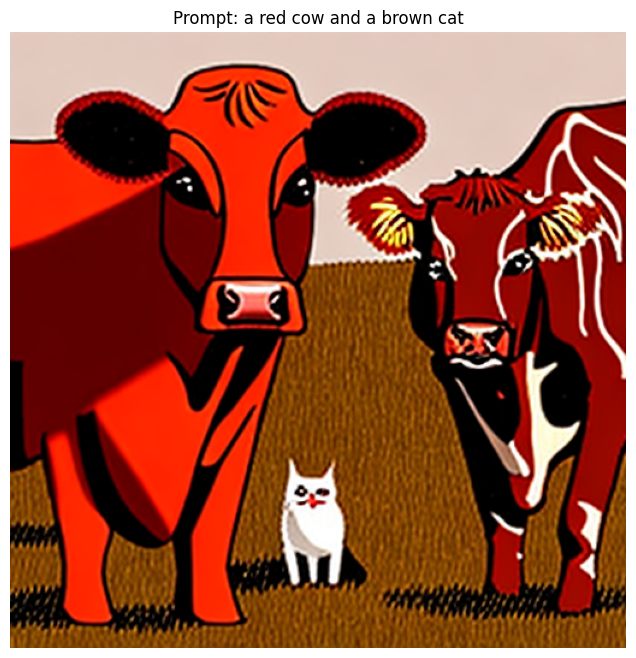

In [16]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 8))
generated_image = generated.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
normalized_image = (generated_image - generated_image.min()) / (generated_image.max() - generated_image.min())
normalized_image = normalized_image.astype("float32")
plt.axis("off")
plt.imshow(normalized_image)
plt.title(f"Prompt: {prompt}", fontsize=12)
plt.show()